In [1]:
# DS776 Auto-Update (runs in ~2 seconds, only updates when needed)
# If this cell fails, see Lessons/Course_Tools/AUTO_UPDATE_SYSTEM.md for help
%run ../../Lessons/Course_Tools/auto_update_introdl.py

⚠️ 🖥️  Hyperstack environment detected - using aggressive cleanup
📦 Source version: 1.6.7


✅ Installed version: 1.6.7
ℹ️ Location: /usr/local/lib/python3.12/dist-packages


✅ introdl v1.6.7 already up to date
✅ API keys file exists
ℹ️ Cloud environment (CoCalc/Colab) detected


# Homework 05 Assignment
**Name:** [Student Name Here]  
**Total Points:** 50

## Submission Checklist
- [ ] All code cells executed with output saved
- [ ] All questions answered
- [ ] Notebook converted to HTML (use the Homework_05_Utilities notebook)
- [ ] Canvas notebook filename includes `_GRADE_THIS_ONE`
- [ ] Files uploaded to Canvas

---

# Transfer Learning

In this homework you'll experiment with applying transfer learning for fine-grained classification using the Flowers102 dataset in torchvision.datasets. Fine-grained classification is when you have many categories or classes that are similar like related species of flowers. Or, for example, trying to distinguish breeds of dogs as opposed to cats, dogs, and foxes.

Note: we were able to train all the models described in this homework in about 40 minutes on the T4 Compute Server. The ConvNeXt model was the biggest and took the most time.

In [1]:
# === YOUR IMPORTS HERE ===
# Add any additional imports you need below this line

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset,DataLoader
from torch.optim.lr_scheduler import OneCycleLR
from torchinfo import summary

import matplotlib.pyplot as plt

import torchvision.transforms.v2 as transforms
from torchvision.datasets import Flowers102
from torchvision.datasets import ImageFolder
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights
from collections import Counter

#import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import seaborn as sns

from introdl.utils import get_device, load_results, load_model, summarizer, config_paths_keys
from introdl.idlmam import train_network
from introdl.visul import plot_training_metrics, create_image_grid,plot_transformed_images, evaluate_classifier

# Configure paths
paths = config_paths_keys()
DATA_PATH = paths['DATA_PATH']
MODELS_PATH = paths['MODELS_PATH']
# === END YOUR IMPORTS ===

✅ Environment: Unknown Environment | Course root: /mnt/e/GDrive_baggett.jeff/Teaching/Classes_current/2025-2026_Fall_DS776/DS776
   Using workspace: <DS776_ROOT_DIR>/home_workspace

📂 Storage Configuration:
   DATA_PATH: <DS776_ROOT_DIR>/home_workspace/data
   MODELS_PATH: <DS776_ROOT_DIR>/Homework/Homework_05/Homework_05_Models (local to this notebook)
   CACHE_PATH: <DS776_ROOT_DIR>/home_workspace/downloads
🔑 API keys: 8 loaded from home_workspace/api_keys.env
🔐 Available: GEMINI_API_KEY, GOOGLE_API_KEY, GROQ_API_KEY... (8 total)
✅ HuggingFace Hub: Logged in
💰 OpenRouter credit: $9.94
📦 introdl v1.6.7 ready



## [5 pts] Data Exploration

First, let's explore the Flowers102 dataset to understand what we're working with. Load the dataset, examine the number of classes, display some sample images with their labels, and analyze the dataset size and structure.



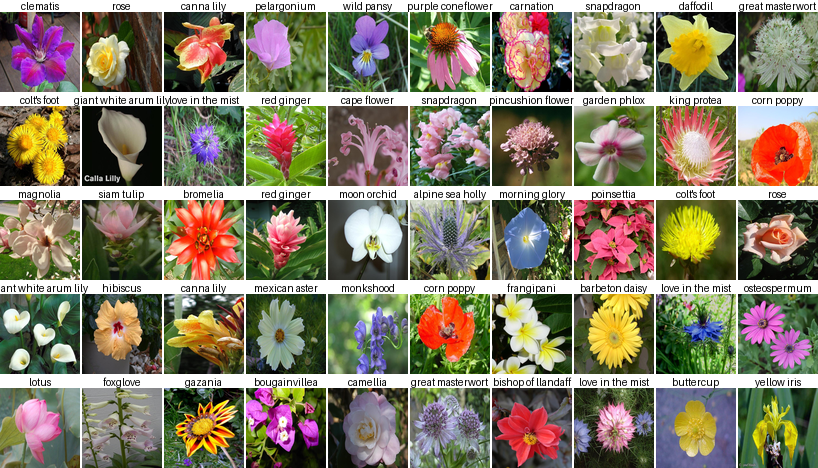

Number of images in train split: 1020
Number of images in valid split: 1020
Number of images in test split: 6149


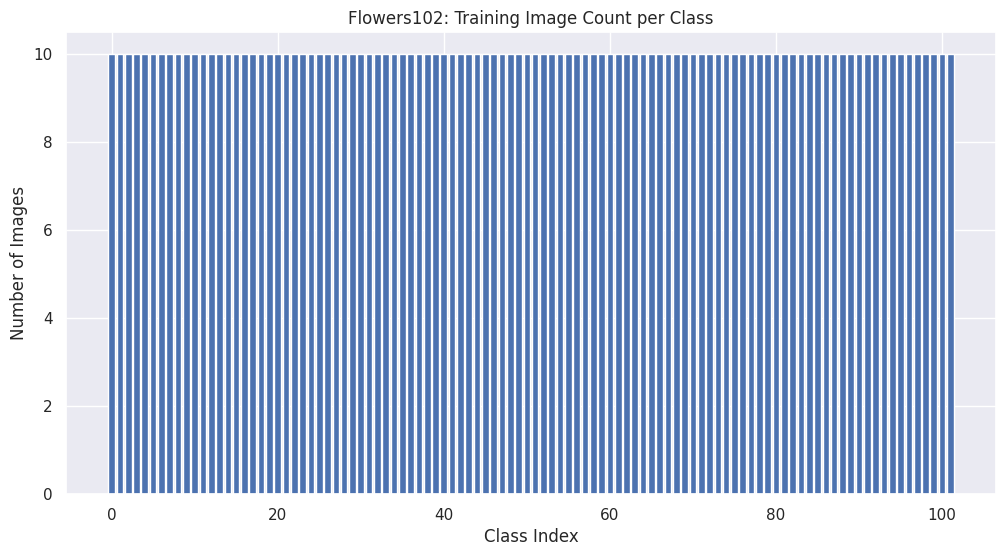

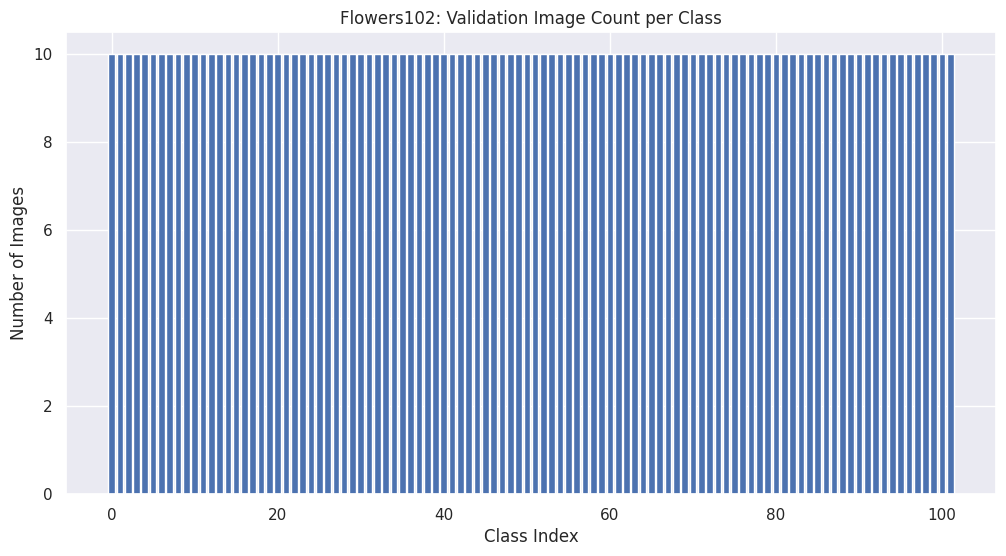

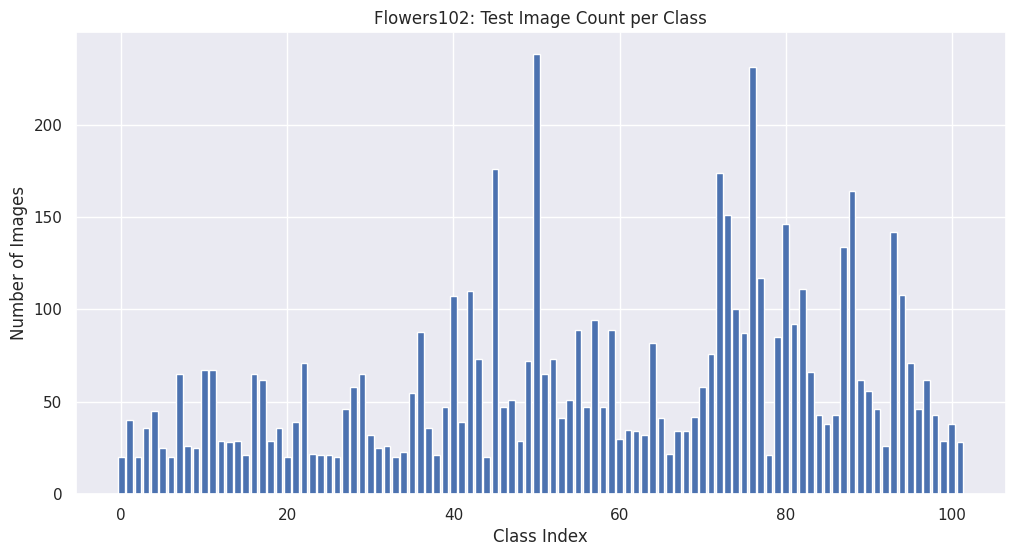

In [2]:
# === YOUR CODE HERE ===
# TODO: Load the Flowers102 dataset and explore its structure
# - Load training, validation, and test splits
orig_train_dataset = Flowers102(root=DATA_PATH, split='train', download=True)
orig_valid_dataset = Flowers102(root=DATA_PATH, split='val', download=True)
orig_test_dataset = Flowers102(root=DATA_PATH, split='test', download=True)

# Display a grid of images
create_image_grid(orig_train_dataset, 5, 10, img_size=(80,80), show_labels=True, dark_mode=False)
#create_image_grid(orig_valid_dataset, 5, 10, img_size=(80,80), show_labels=True, dark_mode=False)

# - Print dataset sizes and number of classes
# Print the number of images
print(f"Number of images in train split: {len(orig_train_dataset)}")
print(f"Number of images in valid split: {len(orig_valid_dataset)}")
print(f"Number of images in test split: {len(orig_test_dataset)}")

# - Display sample images with their class labels
#shown in image grid

# - Analyze the class distribution
# Count occurrences of each class label
label_counts_train = Counter(orig_train_dataset._labels)  # Use ._labels if you're on an older version
label_counts_valid = Counter(orig_valid_dataset._labels)
label_counts_test = Counter(orig_test_dataset._labels)

# visualize train data as a bar chart
plt.figure(figsize=(12, 6))
plt.bar(label_counts_train.keys(), label_counts_train.values())
plt.xlabel("Class Index")
plt.ylabel("Number of Images")
plt.title("Flowers102: Training Image Count per Class")
plt.show()

# visualize validation data as a bar chart
plt.figure(figsize=(12, 6))
plt.bar(label_counts_valid.keys(), label_counts_valid.values())
plt.xlabel("Class Index")
plt.ylabel("Number of Images")
plt.title("Flowers102: Validation Image Count per Class")
plt.show()

# visualize test data as a bar chart
plt.figure(figsize=(12, 6))
plt.bar(label_counts_test.keys(), label_counts_test.values())
plt.xlabel("Class Index")
plt.ylabel("Number of Images")
plt.title("Flowers102: Test Image Count per Class")
plt.show()

# === END YOUR CODE ===

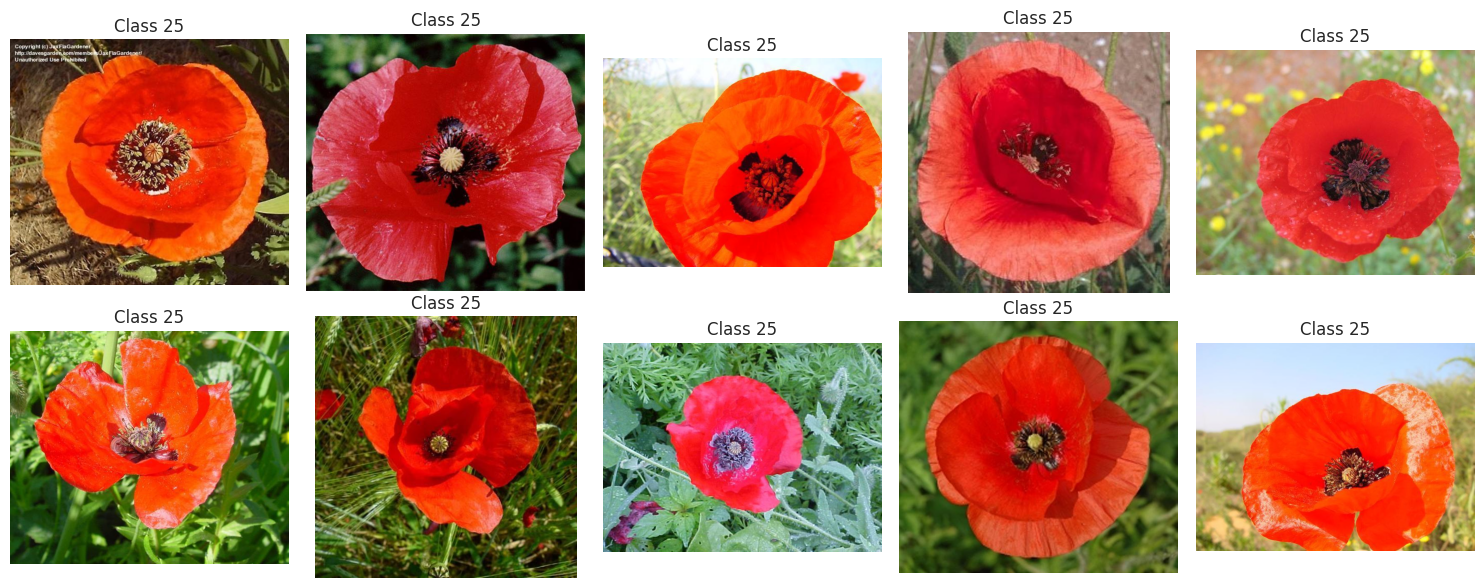

In [3]:
# Filter images belonging to that class
target_class = 25
images_in_class = [img for img, label in orig_train_dataset if label == target_class]

# Display the first 10 images from that class
plt.figure(figsize=(15, 6))
for i in range(min(10, len(images_in_class))):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images_in_class[i])
    plt.axis('off')
    plt.title(f"Class {target_class}")
plt.tight_layout()
plt.show()

## [5 pts] Augmentation and DataLoaders

Build your transforms for training. Remember that for testing and validation the transforms shouldn't add any augmentation. The images should be $224 \times 224$ when transformed since our pretrained models were trained on Imagenet with the same size images. We used `batch_size = 32` on the T4 Compute Servers. For normalization use the statistics from Imagenet since the pretrained models we are using expect that normalization.

In [4]:
# === YOUR CODE HERE ===
# TODO: Create data transforms and DataLoaders
# - Use ImageNet normalization statistics
#validation data normalization - ImageNet statistics
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

# - Create validation/test transforms without augmentation
#validation transform (no augmentation)
transform = transforms.Compose([
    transforms.ToImage(),        # Converts PIL or ndarray to Image tensor
    transforms.ToDtype(torch.float32, scale=True),    
    transforms.Resize(254, max_size=None),        # Resize so the shortest edge is 224
    transforms.CenterCrop(224),
    transforms.Normalize(mean=mean, std=std),
    transforms.ToPureTensor()
])

# - Create training transforms with augmentation (appropriate for fine-grained classification)
#training transform train (augmentation)
transform_train = transforms.Compose([
    transforms.ToImage(),          # Converts PIL or ndarray to Image tensor
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Resize(224, max_size=None),  
    transforms.CenterCrop(224),            # Center crop to 224x224
    transforms.RandomRotation(degrees=15),
    transforms.RandomCrop(224, padding=10),  # Random crop padded img to 224x224
    transforms.RandomHorizontalFlip(p=.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomGrayscale(p=.2),
    transforms.Normalize(mean=mean, std=std),
    transforms.ToPureTensor()
])

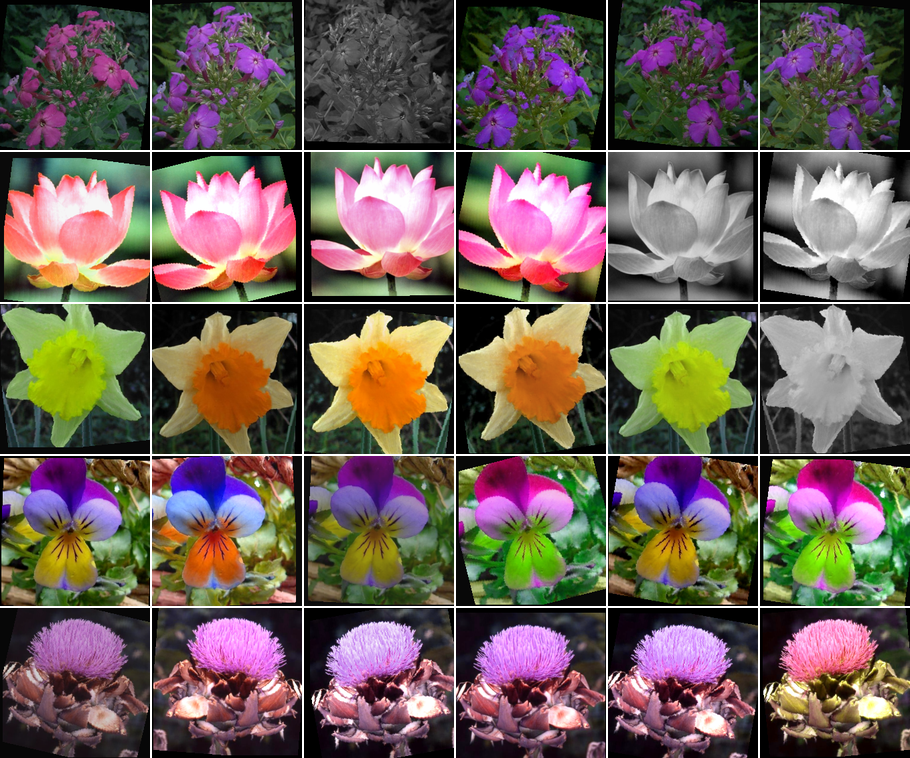

In [8]:
# - Create DataLoaders with batch_size=32
#create augmentations
train_dataset = Flowers102(root=DATA_PATH, split='train', transform=transform_train, download=True)
valid_dataset = Flowers102(root=DATA_PATH, split='val', transform=transform, download=True)

# Display a grid of images
plot_transformed_images(train_dataset, img_size=(150,150), mean=mean, std=std)
#plot_transformed_images(valid_dataset, img_size=(150,150), mean=mean, std=std) #confirmed validation images are not changed in essence

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4)

# === END YOUR CODE ===

## [5 pts] ResNet50

The ResNet models establish good baselines for results.

Build a custom model class for ResNet50 (AI may be helpful here) with an adjustable number of output classes. It should have methods to freeze and unfreeze the backbone. Apply transfer learning instantiating your model with the default Imagenet weights and training with for 5 epochs followed by training for a suitable number of epochs (you may need to experiment). Include graphics or display dataframes to show how the model is converging (at least for the unfrozen training).

Use the training and validation sets here. The test set will be reserved for your final best model.

What kind of validation accuracy are you able to achieve? Is the model overfitting?

Note: the training dataset is already pretty small so downsampling it to expedite experimentation isn't a good idea, but you could temporarily reduce the size of the images to say 128x128 in your transforms to get things working, then go back to 224x224 to train your models. All final results should be done with 224x224.



In [9]:
# view the resnet50 high level model structure
model = models.resnet50(weights="DEFAULT")
summary(model, 
        input_size=(32,3,224,224), 
        col_names=["input_size", "output_size", "num_params"], 
        row_settings=["var_names"],
        depth=1) 

Layer (type (var_name))                  Input Shape               Output Shape              Param #
ResNet (ResNet)                          [32, 3, 224, 224]         [32, 1000]                --
├─Conv2d (conv1)                         [32, 3, 224, 224]         [32, 64, 112, 112]        9,408
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]        [32, 64, 112, 112]        128
├─ReLU (relu)                            [32, 64, 112, 112]        [32, 64, 112, 112]        --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]        [32, 64, 56, 56]          --
├─Sequential (layer1)                    [32, 64, 56, 56]          [32, 256, 56, 56]         215,808
├─Sequential (layer2)                    [32, 256, 56, 56]         [32, 512, 28, 28]         1,219,584
├─Sequential (layer3)                    [32, 512, 28, 28]         [32, 1024, 14, 14]        7,098,368
├─Sequential (layer4)                    [32, 1024, 14, 14]        [32, 2048, 7, 7]          14,964,736
├─Ad

In [10]:
# === YOUR CODE HERE ===
# TODO: Create a custom ResNet50 model class
class ResNet50Custom(nn.Module):
    """
    Custom ResNet-50 model with a modified final classification layer.

    This class wraps torchvision's ResNet-50 and replaces the final fully connected layer
    to match the specified number of output classes. It also provides methods to freeze
    or unfreeze the backbone for transfer learning.
    
    Args:
    num_outputs (int): Number of output classes.
    weights (str or None): If "DEFAULT", loads pretrained weights. If None, initializes randomly.
    weights (ResNet18_Weights or None): Pretrained weights to load for ResNet18. If None, the model is randomly initialized.
    """
    def __init__(self, num_outputs: int, weights = None):
        super(ResNet50Custom, self).__init__()
        
        # - Load pretrained ResNet50 with ImageNet weights
        self.model = models.resnet50(weights=weights) 
            
        # - Replace final classifier layer for 102 flower classes
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_outputs)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the modified ResNet-50.

        Args:
            x (torch.Tensor): Input tensor of shape (B, C, H, W)

        Returns:
            torch.Tensor: Output logits of shape (B, num_outputs)
        """
        return self.model(x)

    # - Add methods to freeze/unfreeze backbone weights
    def freeze_backbone(self):
        """
        Freezes all layers of the backbone except the final classification head.

        Useful for transfer learning when you want to train only the new head.
        """
        #for name, param in self.model.named_parameters(): #original AI suggestion
        #    param.requires_grad = False                   #original AI suggestion
        
        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.fc.parameters():
            param.requires_grad = True

    def unfreeze_backbone(self):
        """
        Unfreezes all layers of the backbone, allowing full fine-tuning.
        """
        for param in self.model.parameters():
            param.requires_grad = True



In [11]:
# - Train with frozen backbone for 5 epochs
model = ResNet50Custom(num_outputs=102, weights = "DEFAULT")
model.freeze_backbone()

loss_func = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.AdamW(model.parameters())  # Adam optimizer

device = get_device()
print(device)

ckpt_file = MODELS_PATH / 'L05_flowers_resnet50_transfer_frozen_backbone_5epochs.pt'
epochs = 5

score_funcs = {'ACC':accuracy_score}
results = train_network(model,
                        loss_func,
                        train_loader,
                        device=device,
                        val_loader=valid_loader,
                        epochs = epochs,
                        optimizer = optimizer,
                        score_funcs = score_funcs,
                        checkpoint_file=ckpt_file,
                        resume_checkpoint = False,
                        pretend_train=True)


cuda
Checkpoint file /mnt/e/GDrive_baggett.jeff/Teaching/Classes_current/2025-2026_Fall_DS776/DS776/Homework/Homework_05/Homework_05_Models/L05_flowers_resnet50_transfer_frozen_backbone_5epochs.pt not found. Proceeding with actual training...


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]


Best model saved at epoch 5 (val loss: 2.1449)


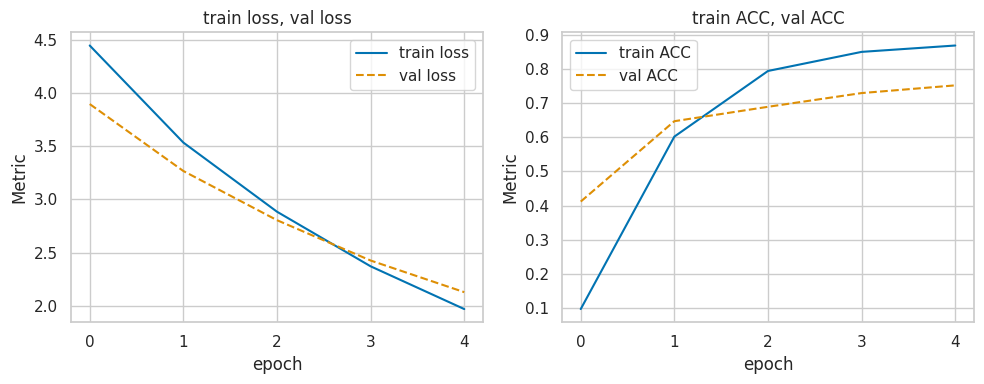

In [39]:
ckpt_file = MODELS_PATH / 'L05_flowers_resnet50_transfer_frozen_backbone_5epochs.pt'
ResNet50Custom5epochs = load_results(ckpt_file)

plot_training_metrics(ResNet50Custom5epochs, [['train loss', 'val loss'], ['train ACC', 'val ACC']])

In [40]:
#...then unfreeze and continue training
model = load_model(ResNet50Custom(num_outputs=102), MODELS_PATH / 'L05_flowers_resnet50_transfer_frozen_backbone_5epochs.pt')
model.unfreeze_backbone()

optimizer = optim.AdamW(model.parameters())  # Adam optimizer
ckpt_file = MODELS_PATH / 'L05_flowers_resnet50_transfer_unfrozen_backbone_post5.pt'
epochs = 5

results = train_network(model,
                        loss_func,
                        train_loader,
                        device=device,
                        val_loader=valid_loader,
                        epochs = epochs,
                        optimizer = optimizer,
                        score_funcs = score_funcs,
                        checkpoint_file=ckpt_file,
                        early_stop_crit='max',
                        early_stop_metric='ACC',
                        patience=3,
                        pretend_train=True)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]


Best model saved at epoch 5 (val ACC: 0.8206)


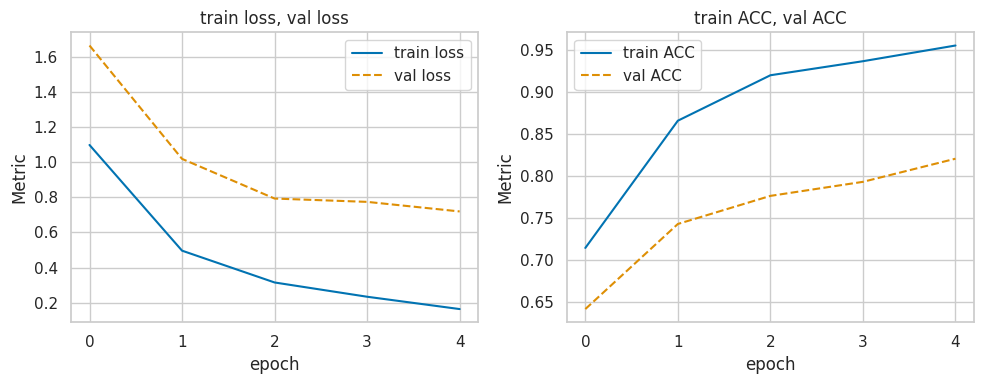

In [41]:
ckpt_file = MODELS_PATH / 'L05_flowers_resnet50_transfer_unfrozen_backbone_post5.pt'
ResNet50Custom5epochs = load_results(ckpt_file)

plot_training_metrics(ResNet50Custom5epochs, [['train loss', 'val loss'], ['train ACC', 'val ACC']])


In [42]:
model = load_model(ResNet50Custom(num_outputs=102), MODELS_PATH / 'L05_flowers_resnet50_transfer_frozen_backbone_5epochs.pt')
model.unfreeze_backbone()

ckpt_file = MODELS_PATH / 'L05_flowers_resnet50_transfer_unfrozen_backbone_post10.pt'
epochs = 10
optimizer = optim.AdamW(model.parameters())  # Adam optimizer

results = train_network(model,
                        loss_func,
                        train_loader,
                        device=device,
                        val_loader=valid_loader,
                        epochs = epochs,
                        optimizer = optimizer,
                        score_funcs = score_funcs,
                        checkpoint_file=ckpt_file,
                        early_stop_crit='max',
                        early_stop_metric='ACC',
                        patience=3,
                        pretend_train=True)


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Early stopping at epoch 7

Best model saved at epoch 5 (val ACC: 0.8186)


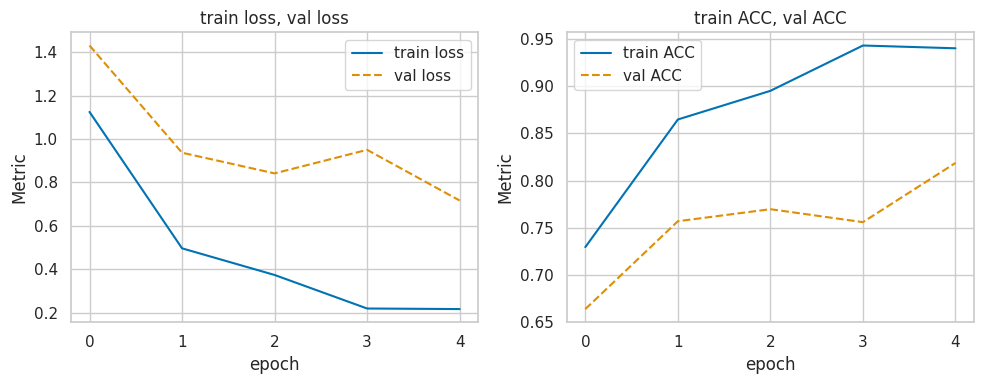

In [43]:
ckpt_file = MODELS_PATH / 'L05_flowers_resnet50_transfer_unfrozen_backbone_post10.pt'
ResNet50Custom5epochs = load_results(ckpt_file)

plot_training_metrics(ResNet50Custom5epochs, [['train loss', 'val loss'], ['train ACC', 'val ACC']])
# === END YOUR CODE ===

📝 **What validation accuracy did you achieve? Is the model overfitting?**

## [5 pts] EfficientNet V2 Small

EfficientNet models are a modern upgrade to traditional convolutional neural networks, offering improved performance and efficiency. Repeat what you did for ResNet50 for EfficientNet V2 Small. Use AI to search for how to load it in torchvision and how to adapt in your custom model class.

In [11]:
# view the efficientnetV2Small high level model structure
model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)

# Set to evaluation mode
#print(model)
model.classifier
#model.classifier[1]

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [12]:
#summary of model
summary(model, 
        input_size=(32,3,224,224), 
        col_names=["input_size", "output_size", "num_params"], 
        row_settings=["var_names"],
        depth=1) 

Layer (type (var_name))                                      Input Shape               Output Shape              Param #
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]         [32, 1000]                --
├─Sequential (features)                                      [32, 3, 224, 224]         [32, 1280, 7, 7]          20,177,488
├─AdaptiveAvgPool2d (avgpool)                                [32, 1280, 7, 7]          [32, 1280, 1, 1]          --
├─Sequential (classifier)                                    [32, 1280]                [32, 1000]                1,281,000
Total params: 21,458,488
Trainable params: 21,458,488
Non-trainable params: 0
Total mult-adds (G): 91.20
Input size (MB): 19.27
Forward/backward pass size (MB): 6234.30
Params size (MB): 85.83
Estimated Total Size (MB): 6339.40

In [13]:
# === YOUR CODE HERE ===
# TODO: Create EfficientNet V2 Small model
# - Load pretrained EfficientNet V2 Small with ImageNet weights
# - Adapt the model for 102 flower classes
# - Apply the same two-phase training approach as ResNet50
class EfficientNetV2SmallCustom(nn.Module):
    """
    Custom EfficientNet V2 Small model with a modified classification head.

    This class wraps torchvision's EfficientNet V2 Small and replaces the final classifier
    to match the specified number of output classes. It also provides methods to freeze
    or unfreeze the backbone for transfer learning.

    Args:
        num_outputs (int): Number of output classes.
        weights: If "DEFAULT", loads pretrained weights. If None, initializes randomly.
    """
    def __init__(self, num_outputs: int, weights = None):
        super(EfficientNetV2SmallCustom, self).__init__()      

    # Load EfficientNet V2 Small with or without pretrained weights
        self.model = models.efficientnet_v2_s(weights=weights) 
    
        #if weights == "DEFAULT":
        #    self.model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)

        #else:
        #self.model = models.efficientnet_v2_s(weights=None)

        # Replace the classifier head
        in_features = self.model.classifier[1].in_features
        self.model.classifier[1] = nn.Linear(in_features, num_outputs)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the modified EfficientNet V2 Small.

        Args:
            x (torch.Tensor): Input tensor of shape (B, C, H, W)

        Returns:
            torch.Tensor: Output logits of shape (B, num_outputs)
        """
        return self.model(x)
    
    def freeze_backbone(self):
        """
        Freezes all layers of the backbone except the final classification head.

        Useful for transfer learning when training only the new head.
        """            
        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.classifier.parameters(): #unfreeze the classifier layer only
            param.requires_grad = True

    def unfreeze_backbone(self):
        """
        Unfreezes all layers of the backbone, allowing full fine-tuning.
        """
        for param in self.model.parameters():
            param.requires_grad = True



In [14]:
# - Create DataLoaders with batch_size=32
#repeating trying to resove error
#create augmentations
train_dataset = Flowers102(root=DATA_PATH, split='train', transform=transform_train, download=True)
valid_dataset = Flowers102(root=DATA_PATH, split='val', transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4)

In [15]:
model = EfficientNetV2SmallCustom(num_outputs=102, weights = "DEFAULT")
model.freeze_backbone()

loss_func = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.AdamW(model.parameters())  # Adam optimizer

device = get_device()
print(device)

ckpt_file = MODELS_PATH / 'L05_flowers_EfficientNetV2Small_transfer_frozen_backbone_5epochs.pt'
epochs = 5

score_funcs = {'ACC':accuracy_score}
results = train_network(model,
                        loss_func,
                        train_loader,
                        device=device,
                        val_loader=valid_loader,
                        epochs = epochs,
                        optimizer = optimizer,
                        score_funcs = score_funcs,
                        checkpoint_file=ckpt_file,
                        pretend_train = True)

cpu


Pretend Training:   0%|          | 0/5 [00:00<?, ?it/s]

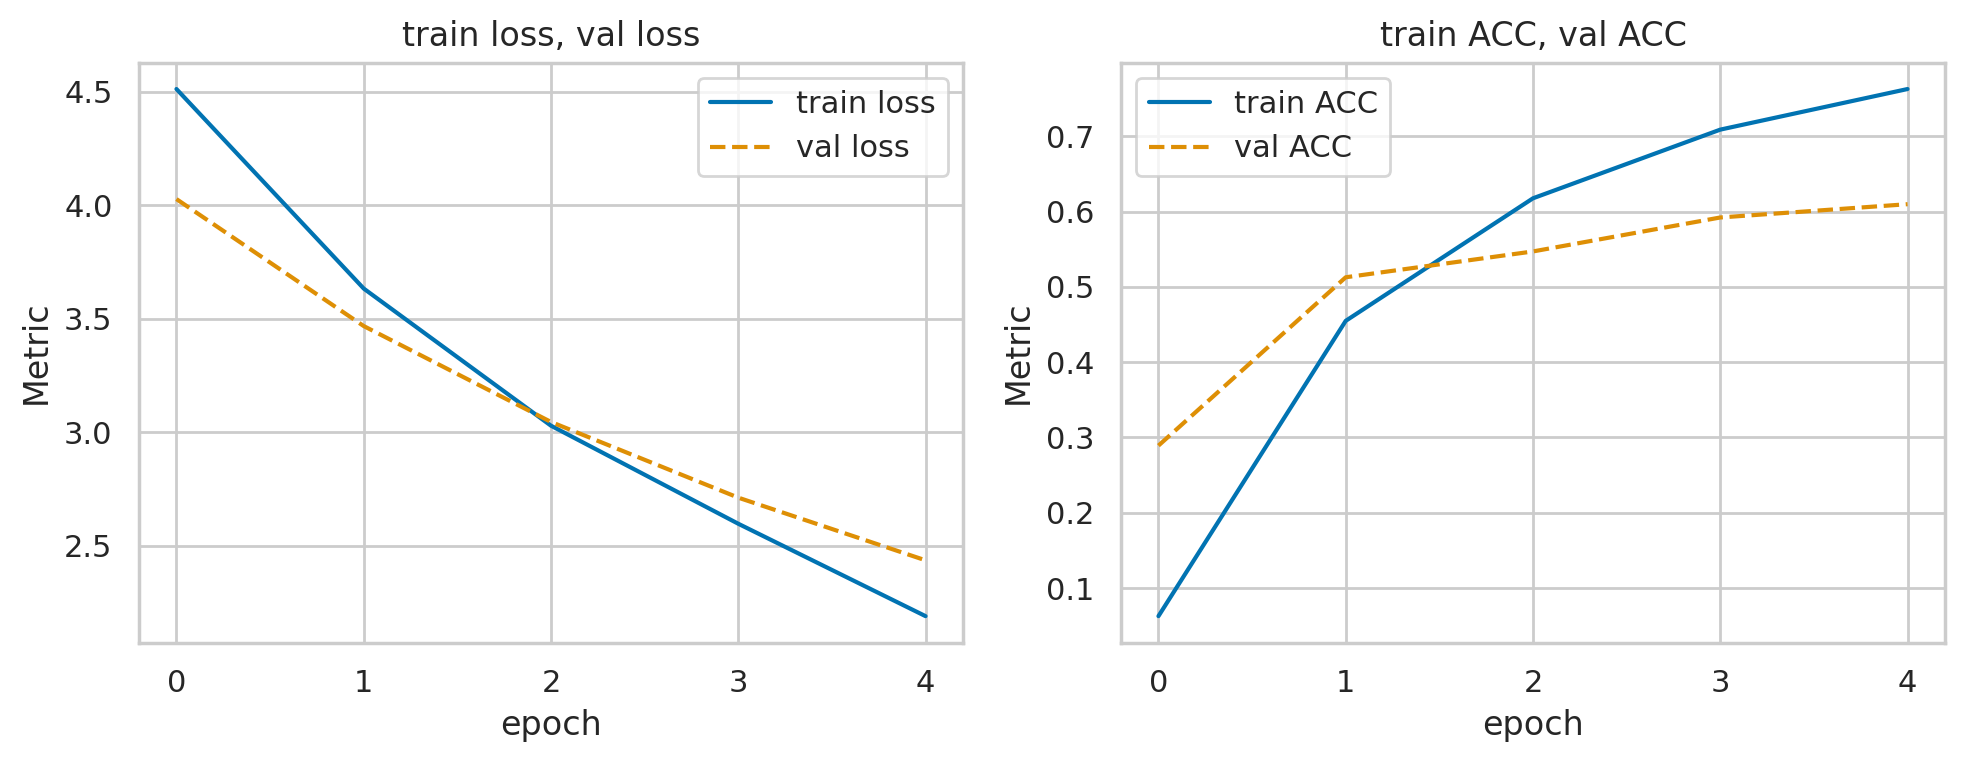

In [16]:
ckpt_file = MODELS_PATH / 'L05_flowers_EfficientNetV2Small_transfer_frozen_backbone_5epochs.pt'
EfficientNetV2SmallCustom = load_results(ckpt_file)

plot_training_metrics(EfficientNetV2SmallCustom, [['train loss', 'val loss'], ['train ACC', 'val ACC']])

In [17]:
model = load_model(EfficientNetV2SmallCustom(num_outputs=102), MODELS_PATH / 'L05_flowers_EfficientNetV2Small_transfer_frozen_backbone_5epochs.pt')
model.unfreeze_backbone()

optimizer = optim.AdamW(model.parameters())  # Adam optimizer
ckpt_file = MODELS_PATH / 'L05_flowers_resnet50_transfer_unfrozen_backbone_post10.pt'
epochs = 10


results = train_network(model,
                        loss_func,
                        train_loader,
                        device=device,
                        val_loader=valid_loader,
                        epochs = epochs,
                        optimizer = optimizer,
                        score_funcs = score_funcs,
                        checkpoint_file=ckpt_file,
                        early_stop_crit='max',   #use early stopping base on accuracy
                        early_stop_metric='ACC',
                        patience=3,
                        pretend_train=True)

TypeError: 'DataFrame' object is not callable

In [0]:
ckpt_file = MODELS_PATH / 'L05_flowers_resnet50_transfer_unfrozen_backbone_post10.pt'
EfficientNetV2SmallCustom = load_results(ckpt_file)

plot_training_metrics(EfficientNetV2SmallCustom, [['train loss', 'val loss'], ['train ACC', 'val ACC']])
# === END YOUR CODE ===

## [5 pts] ConvNeXt Small

ConvNeXt models are a family of convolutional neural networks that aim to modernize the design of traditional CNNs by incorporating elements from vision transformers. They provide a strong performance baseline for various computer vision tasks. Use transfer learning to train a ConvNeXT Small (not Tiny) model on Flowers102.

In [50]:
# view the convnext high level model structure
model = models.convnext_small(weights=models.ConvNeXt_Small_Weights.DEFAULT)

# Set to evaluation mode
#print(model)
model.classifier
#model.classifier[2]

Sequential(
  (0): LayerNorm2d((768,), eps=1e-06, elementwise_affine=True)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=768, out_features=1000, bias=True)
)

In [51]:
#summary of model
summary(model, 
        input_size=(32,3,224,224), 
        col_names=["input_size", "output_size", "num_params"], 
        row_settings=["var_names"],
        depth=1) 

Layer (type (var_name))                                 Input Shape               Output Shape              Param #
ConvNeXt (ConvNeXt)                                     [32, 3, 224, 224]         [32, 1000]                --
├─Sequential (features)                                 [32, 3, 224, 224]         [32, 768, 7, 7]           49,453,152
├─AdaptiveAvgPool2d (avgpool)                           [32, 768, 7, 7]           [32, 768, 1, 1]           --
├─Sequential (classifier)                               [32, 768, 1, 1]           [32, 1000]                770,536
Total params: 50,223,688
Trainable params: 50,223,688
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 13.16
Input size (MB): 19.27
Forward/backward pass size (MB): 6628.50
Params size (MB): 200.84
Estimated Total Size (MB): 6848.61

In [52]:
# === YOUR CODE HERE ===
# TODO: Create ConvNeXt Small model
# - Load pretrained ConvNeXt Small with ImageNet weights
# - Adapt the model for 102 flower classes
# - Apply the same two-phase training approach as previous models
class ConvNeXtSmallCustom(nn.Module):
    """
    Custom ConvNeXt Small model with a modified classification head.

    This class wraps torchvision's ConvNeXt Small and replaces the final classifier
    to match the specified number of output classes. It also provides methods to freeze
    or unfreeze the backbone for transfer learning.

    Args:
        num_outputs (int): Number of output classes.
        weights (str or None): If "DEFAULT", loads pretrained weights. If None, initializes randomly.
    """
    def __init__(self, num_outputs: int, weights = None):
        super(ConvNeXtSmallCustom, self).__init__()

        # Load ConvNeXt Small with or without pretrained weights
        if weights == "DEFAULT":
            self.model = models.convnext_small(weights=models.ConvNeXt_Small_Weights.DEFAULT)
        else:
            self.model = models.convnext_small(weights=None)
            
        # Replace the classifier head
        in_features = self.model.classifier[2].in_features
        self.model.classifier[2] = nn.Linear(in_features, num_outputs)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the modified ConvNeXt Small.

        Args:
            x (torch.Tensor): Input tensor of shape (B, C, H, W)

        Returns:
            torch.Tensor: Output logits of shape (B, num_outputs)
        """
        return self.model(x)
        
    def freeze_backbone(self):
        """
        Freezes all layers of the backbone except the final classification head.

        Useful for transfer learning when training only the new head.
        """
        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.classifier.parameters():  #unfreeze the classifier layer only
            param.requires_grad = True

    def unfreeze_backbone(self):
        """
        Unfreezes all layers of the backbone, allowing full fine-tuning.
        """
        for param in self.model.parameters():
            param.requires_grad = True

In [53]:
model = ConvNeXtSmallCustom(num_outputs=102, weights = "DEFAULT")
model.freeze_backbone()

loss_func = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.AdamW(model.parameters())  # Adam optimizer

device = get_device()
print(device)

ckpt_file = MODELS_PATH / 'L05_flowers_ConvNeXtSmallCustom_transfer_frozen_backbone_5epochs.pt'
epochs = 5

score_funcs = {'ACC':accuracy_score}
results = train_network(model,
                        loss_func,
                        train_loader,
                        device=device,
                        val_loader=valid_loader,
                        epochs = epochs,
                        optimizer = optimizer,
                        score_funcs = score_funcs,
                        checkpoint_file=ckpt_file,
                        pretend_train=True)

cuda


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]


Best model saved at epoch 5 (val loss: 1.5195)


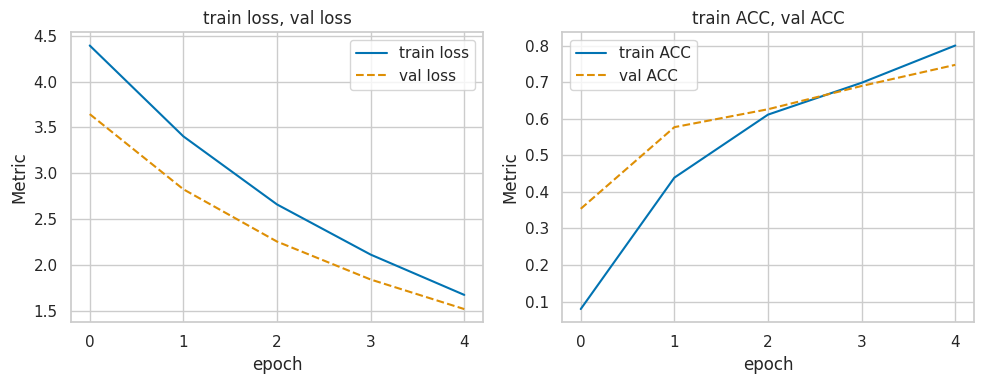

In [54]:
ckpt_file = MODELS_PATH / 'L05_flowers_ConvNeXtSmallCustom_transfer_frozen_backbone_5epochs.pt'
ConvNeXtSmallCustom = load_results(ckpt_file)

plot_training_metrics(ConvNeXtSmallCustom, [['train loss', 'val loss'], ['train ACC', 'val ACC']])

In [55]:
model = load_model(ConvNeXtSmallCustom(num_outputs=102), MODELS_PATH / 'L05_flowers_ConvNeXtSmallCustom_transfer_frozen_backbone_5epochs.pt')
model.unfreeze_backbone()

ckpt_file = MODELS_PATH / 'L05_flowers_ConvNeXtSmallCustom_transfer_unfrozen_backbone_post5.pt'
epochs = 5
optimizer = optim.AdamW(model.parameters())  # Adam optimizer

results = train_network(model,
                        loss_func,
                        train_loader,
                        device=device,
                        val_loader=valid_loader,
                        epochs = epochs,
                        optimizer = optimizer,
                        score_funcs = score_funcs,
                        checkpoint_file=ckpt_file,
                        early_stop_crit='max',    #early stopping based on accuracy
                        early_stop_metric='ACC',
                        patience=3,
                        pretend_train=False)

TypeError: 'DataFrame' object is not callable

In [0]:
ckpt_file = MODELS_PATH / 'L05_flowers_ConvNeXtSmallCustom_transfer_unfrozen_backbone_post5.pt'
ConvNeXtSmallCustom = load_results(ckpt_file)

plot_training_metrics(ConvNeXtSmallCustom, [['train loss', 'val loss'], ['train ACC', 'val ACC']])
# === END YOUR CODE ===

## [5 pts] ViT Small

Vision Transformers (ViTs) are a type of neural network architecture that leverages the transformer model, originally designed for natural language processing, to process image data. Unlike Convolutional Neural Networks (CNNs), which use convolutional layers to capture spatial hierarchies, ViTs divide images into patches and process them as sequences, allowing for global context understanding. ViTs typically require more data to train from scratch compared to CNNs, but they can be effectively used for transfer learning on smaller datasets if the images are similar to those in the Imagenet dataset. We'll learn more about transformer models in the second half of the course.

We'll use the timm library which doesn't seem to be installed in CoCalc.
To use ViT Small from the timm library, you can install timm with the following command:

```python
!pip install timm
```

Then, load the pre-trained ViT Small model with:

```python
import timm
model = timm.create_model('vit_small_patch16_224', pretrained=True)
```

(Note: you'll need to copy this code from this markdown cell to a regular code cell for the installation to work correctly.)

The ViT Small model is pretrained on Imagenet and expects the same size images and same normalization as other models. Typically we fine tune the whole model and don't train with a frozen backbone. The learning rates used are usually smaller, too. Do the same kind of fine tuning as you've done above using OneCycleLR with max_lr = 0.0005. We found that the number of epochs needed was similar to the total number of epochs used in the two-phase training used by our other models.



In [56]:
# === YOUR CODE HERE ===
# TODO: Install and use ViT Small from timm library
# - Install timm library
!pip install timm
import timm
# - Create ViT Small model with ImageNet pretrained weights
model = timm.create_model('vit_small_patch16_224', pretrained=True)

#summary of model
summary(model, 
        input_size=(32,3,224,224), 
        col_names=["input_size", "output_size", "num_params"], 
        row_settings=["var_names"],
        depth=1) 


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip


Layer (type (var_name))                  Input Shape               Output Shape              Param #
VisionTransformer (VisionTransformer)    [32, 3, 224, 224]         [32, 1000]                76,032
├─PatchEmbed (patch_embed)               [32, 3, 224, 224]         [32, 196, 384]            295,296
├─Dropout (pos_drop)                     [32, 197, 384]            [32, 197, 384]            --
├─Identity (patch_drop)                  [32, 197, 384]            [32, 197, 384]            --
├─Identity (norm_pre)                    [32, 197, 384]            [32, 197, 384]            --
├─Sequential (blocks)                    [32, 197, 384]            [32, 197, 384]            21,293,568
├─LayerNorm (norm)                       [32, 197, 384]            [32, 197, 384]            768
├─Identity (fc_norm)                     [32, 384]                 [32, 384]                 --
├─Dropout (head_drop)                    [32, 384]                 [32, 384]                 --
├─Linear (head)  

In [57]:
#show details of Linear layer
#print(model)
model.head

Linear(in_features=384, out_features=1000, bias=True)

In [58]:
# - Fine-tune the whole model (don't use frozen backbone approach)
# - Use OneCycleLR scheduler with max_lr=0.0005
class VitSmallCustom(nn.Module):
    """
    Custom VitSmallCustom model with a modified classification head.

    replaces the final classifier to match the specified number of output classes

    Args:
        num_outputs (int): Number of output classes.
        weights: If "DEFAULT", loads pretrained weights. If None, initializes randomly.
    """
    def __init__(self, num_outputs: int, weights = "DEFAULT"):  #Default to pretrained weights
        super(VitSmallCustom, self).__init__()

        # Load VitSmallCustom with or without pretrained weights
        if weights == "DEFAULT":
            self.model = timm.create_model('vit_small_patch16_224', pretrained=True)
        else:
            self.model = timm.create_model('vit_small_patch16_224', pretrained=False)
            
        # Replace the classifier head
        in_features = self.model.head.in_features
        self.model.head = nn.Linear(in_features, num_outputs)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the modified model.

        Args:
            x (torch.Tensor): Input tensor of shape (B, C, H, W)

        Returns:
            torch.Tensor: Output logits of shape (B, num_outputs)
        """
        return self.model(x)
    
    #do not need to freeze and unfreeze, so not including those methods

In [59]:
model = VitSmallCustom(num_outputs=102, weights = "DEFAULT")

loss_func = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.AdamW(model.parameters(), lr=0.0005)  # Adam optimizer
epochs = 10

max_lr = 0.0005
scheduler = OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

device = get_device()
print(device)

ckpt_file = MODELS_PATH / 'L05_flowers_VitSmallCustom_transfer_10epochs.pt'

score_funcs = {'ACC':accuracy_score}
results = train_network(model,
                        loss_func,
                        train_loader,
                        device=device,
                        val_loader=valid_loader,
                        epochs = epochs,
                        optimizer = optimizer,
                        score_funcs = score_funcs,
                        checkpoint_file=ckpt_file,
                        lr_schedule = scheduler,
                        scheduler_step_per_batch=True,
                        pretend_train=True)

cuda


Pretend Training:   0%|          | 0/10 [00:00<?, ?it/s]

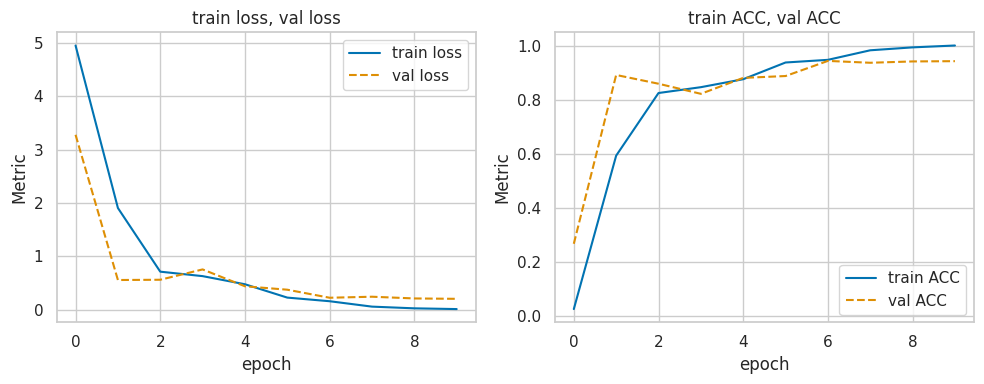

In [60]:
ckpt_file = MODELS_PATH / 'L05_flowers_VitSmallCustom_transfer_10epochs.pt'
VitSmallCustom = load_results(ckpt_file)

plot_training_metrics(VitSmallCustom, [['train loss', 'val loss'], ['train ACC', 'val ACC']])
# === END YOUR CODE ===

## [10 pts] Apply Best Model to Test Data and Evaluate

Write a brief summary of your investigations above. Include a graph comparing the training metrics from the fine-tuning phases on the validation data from above.

Generate a classification report comparing the predictions of your best model to the ground truth labels on the test dataset. Summarize the highlights of the report. A confusion matrix display probably isn't helpful because there are so many classes (set `display_confusion=False` if use `evaluate_classifier` from `introdl.utils`.) But you can look at slices of the confusion matrix. Try to identify at least two classes which are being confused by your model and display examples, with proper labels, from those classes.

In [86]:
# === YOUR CODE HERE ===
# TODO: Compare all models and evaluate best one on test data
# - Create comparison plots of validation metrics from all models
ResNet50  = load_results(MODELS_PATH / 'L05_flowers_resnet50_transfer_unfrozen_backbone_post10.pt')

EffNetSm = load_results(MODELS_PATH / 'L05_flowers_EfficientNetV2Small_transfer_unfrozen_backbone_post5.pt')

ConvNext = load_results(MODELS_PATH / 'L05_flowers_ConvNeXtSmallCustom_transfer_unfrozen_backbone_post5.pt')

VitSm = load_results(MODELS_PATH / 'L05_flowers_VitSmallCustom_transfer_10epochs.pt')

plot_training_metrics([ResNet50, EffNetSm, ConvNext, VitSm], 
                      [['val loss'],['val ACC']],
                      df_labels=['ResNet50','EffNetSm', 'ConvNext','VitSm'])



RuntimeError: PytorchStreamReader failed reading zip archive: failed finding central directory

In [87]:
# - Select the best performing model based on validation results
# - Evaluate the best model on the test dataset
# - Generate classification report (set display_confusion=False)

model = load_model(VitSmallCustom(num_outputs=102), MODELS_PATH / 'L05_flowers_VitSmallCustom_transfer_10epochs.pt')
device = get_device()
conf_mat,report,misses_dataset=evaluate_classifier(model, val_dataset, device, display_confusion=False)

TypeError: 'DataFrame' object is not callable

In [0]:
# show the classification report
print(report)

In [0]:
# - Identify and display examples of confused classes
create_image_grid(misses_dataset, nrows=2, ncols=5, img_size=(200, 200), show_labels=True, mean=mean, std=std)


# === END YOUR CODE ===

📝 **YOUR SUMMARY OF MODEL COMPARISONS:**

## [8 pts] Questions from Chapter 13.1-13.3 Reading

**Question 1 (3 pts):** Section 13.1 explains the fundamental concept of transfer learning and when it works best. Based on the reading:

- What is the key advantage of transfer learning over training from scratch, especially regarding labeled data requirements?
- Why do transfer learning approaches work particularly well for computer vision tasks? What structural similarities make this possible?
- According to the reading, what are the two critical factors that determine transfer learning success: dataset size and what other factor?

📝 **YOUR ANSWER HERE: Transfer learning gives training with new data a head start by potentially supplying a better starting point for parameter weights in the early stages of training. These approaches work well with images because the images themselves can have common features.  The second critical factor for transfer learning success is similar data structure between the pre\-trained data set and the new data set.**

**Question 2 (3 pts):** Section 13.2 compares warm start vs frozen weight approaches. From your implementation above and the reading:

- Explain the difference between "warm start" and "frozen weights" approaches in transfer learning. What parameters change in each method?
- According to Figure 13.5 and the discussion, when should you prefer frozen weights over warm start? What advantage does frozen weights provide with limited data?
- In your experiments above, how did the performance compare between different transfer learning approaches? Does this match the textbook's predictions?

📝 **YOUR ANSWER HERE:  Frozen weights use the parameters from the pretrained model for the frozen layers and training only occurs on unfrozen layers \(such as our replaced classifier layers in the examples\). Warm starts do not have to come from a pre\-trained model.  A warm start scenario is just one where you start with some set of starting weights, rather than simply random weights when training.  In warm starts all parameters can change.  With frozen weights, the pre\-trained parameters on the frozen layers do not change.  Using frozen weights with smaller datasets allows us to take advantage of the patterns the model has already learned to converge faster and to reduce overfitting to a small dataset.  In the homework examples, training first with frozen weights \(training just the classifier\) and then unfreezing the layers allowed for very fast convergence, sometimes in as few as 3 epochs.  Overfitting was still an issue, but could be managed with early stopping.**

**Question 3 (2 pts):** Section 13.3 discusses the relationship between dataset size, number of parameters, and model performance:

- The reading presents a simplified equation: θ = θ* + ε⋅D/N. Explain what this equation means in practical terms for model training.
- How does freezing weights effectively reduce the "D" term in this equation, and why does this help when you have limited training data?

📝 **YOUR ANSWER HERE: The best weights we can find in our model are limited by the noise in the data, which is increased by model complexity \(number of parameters\) and decreased by the volume of labeled data we have.  Freezing the weights of most layers means that very few weights are being adjusted during training, reducing complexity of training.  When you have very little labeled data for training, reducing complexity helps to reduce the noise, therefore, helping achieve a more accurate result with a smaller dataset.**


## [2 pts] Reflection

1. What, if anything, did you find difficult to understand for this lesson? Why?

📝 **YOUR ANSWER HERE:  Transfer learning overall was a new concept and the materials helped understand the value of applying.**

2. What resources did you find supported your learning most and least for this lesson? (Be honest - I use your input to shape the course.)

📝 **YOUR ANSWER HERE: The text was more helpful for this lesson, but the lesson and homework notebooks were still my favorite, as they provided the practical application.**
